In [5]:
%pylab nbagg
from tvb.simulator.lab import *

epileptors = models.Epileptor(Ks=-0.2, Kf=0.1, r=0.00015)
epileptors.x0 = np.ones((76))*-2.4 #set all brain regions non-epileptic
epileptors.x0[[69, 72]] = np.ones((2))*-1.8 #overwrite as epileptogenic; borderline epileptic ('close to epilepsy threshold')
epileptors.x0[[62, 47, 40]] = np.ones((3))*-1.6 #overwrite as epileptic neural populations

con = connectivity.Connectivity(load_default=True)

coupl = coupling.Difference(a=1.)

hiss = noise.Additive(nsig = numpy.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss) #define delta time for time series

# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)

pre_expr = "-y0+y3" #5 abstract state variables (plus one that is implicitly defined), this combination was found to correspond to EEG signals

#Initialise some Monitors with period in physical time
mon_EEG = monitors.EEG(load_default=True,
                       region_mapping=rm,
                       period=1.)
mon_SEEG = monitors.iEEG(load_default=True,
                         region_mapping=rm,
                         period=1.,
                        ) #intracranial EEG (iEEG) is a particular/specific type of stereoEEG (SEEG)

#Bundle them
what_to_watch = (mon_EEG, mon_SEEG)

SIM_LEN = 50000 #5 second simulation
INTERACTIVE_FREQ = 1

weighting = numpy.zeros((76))
weighting[[69, 72]] = numpy.array([2.]) #stimulus amplification

#this is our stimulus, simple pulse whose amplitude/value can be changed each differential instant
eqn_t = equations.PulseTrain()
eqn_t.parameters["T"] = SIM_LEN
eqn_t.parameters["onset"] = 0.0
eqn_t.parameters["tau"] = SIM_LEN
eqn_t.parameters["amp"] = 0.0
stim = patterns.StimuliRegion(temporal = eqn_t,
                              connectivity = con, 
                              weight = weighting)

#Configure space and time
stim.configure_space()
stim.configure_time(numpy.arange(0., SIM_LEN, heunint.dt))

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = epileptors, 
                          connectivity = con,
                          coupling = coupl, 
                          integrator = heunint, 
                          monitors = what_to_watch,
                          stimulus = stim)
sim.configure()




Populating the interactive namespace from numpy and matplotlib
WARNING  File 'hemispheres' not found in ZIP.


initial_conditions,None
coupling,Difference(a=1)
stimulus,"StimuliRegion(bound=False, value=None)"
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"(EEG(bound=False, value=None), iEEG(bound=False, value=None))"


In [6]:

eeg_data, eeg_time = [], [0] #for efficiency add a zero as first element so we can eliminate a check in the simulation loop
#seeg_data, seeg_time = [], []

#http://nbviewer.jupyter.org/url/docs.thevirtualbrain.org/demos/smooth_parameter_variation.ipynb <-- perhaps it would be more efficient to "...define a new Model of local dynamics..."
#http://www.thevirtualbrain.org/tvb/zwei/science?key=how <-- how the input stimulus works
counter = 0
stim_duration = 400
stim_triggered = False
stim_refractory = False
for i in range(SIM_LEN / INTERACTIVE_FREQ):
    for eeg, seeg in sim(simulation_length = INTERACTIVE_FREQ):
        if not eeg is None:
            if eeg[0] == eeg_time[counter]:
                continue
            eeg_time.append(eeg[0])
            eeg_data.append(eeg[1][0])


        ###################################################################################################
        ### example one-shot stimulation; replace with your own responsive/closed-loop stimulus here ######
        ### which can depend on previous EEG readings in (eeg_time, eeg_data) #############################
        ### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        if stim_triggered:
            stim_duration -= 1
            if(stim_duration < 0):
                stim_refractory = True
                stim.temporal.parameters["amp"] = 0.0
        elif(counter > 2000 and any(abs(eeg[1][0]) > 1.5e4)):
            if not stim_refractory:
                stim_triggered = True
                stim.temporal.parameters["amp"] = 5.0
        ### <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        ### example one-shot stimulation; replace with your own responsive/closed-loop stimulus here ######
        ### which can depend on previous EEG readings in (eeg_time, eeg_data) #############################
        ###################################################################################################

        counter += 1

C:\Users\Ali\Documents\ISML\TVB_Distribution\tvb_data\Lib\site-packages\IPython\kernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


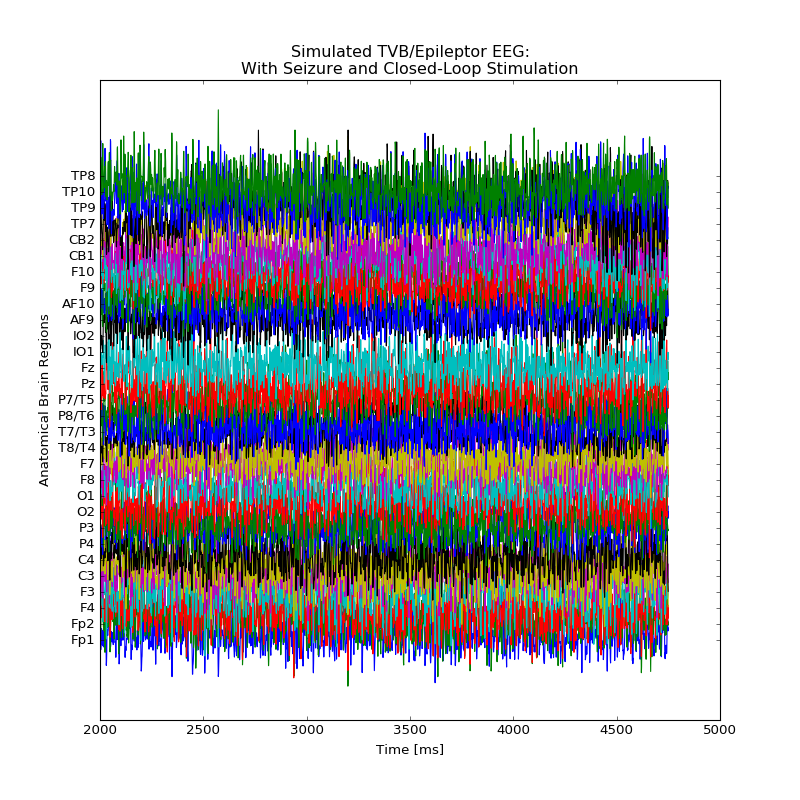

In [7]:
eeg_time.remove(0) #for efficency; see comment above
eeg_data_raw = copy(eeg_data) #I make this available for debugging
eeg_data /= (np.max(eeg_data, 0) - np.min(eeg_data, 0))
eeg_data -= np.mean(eeg_data, 0)
#seeg_data /= (np.max(seeg_data, 0) - np.min(seeg_data, 0))
#seeg_data -= np.mean(seeg_data, 0)

figure(2, figsize=(10,10))
plot(eeg_time[2000:np.minimum(SIM_LEN, counter)], 10*eeg_data[2000:np.minimum(SIM_LEN, counter), :30, 0] + np.r_[:30])
yticks(np.r_[:30], mon_EEG.sensors.labels[:30])
title("Simulated TVB/Epileptor EEG:\nWith Seizure and Closed-Loop Stimulation")
xlabel("Time [ms]")
ylabel("Anatomical Brain Regions")

#figure(4, figsize=(10,10))
#plot(seeg_time[2000:np.minimum(SIM_LEN, counter)], seeg_data[2000:np.minimum(SIM_LEN, counter), :75, 0] + np.r_[:75])
#yticks(np.r_[:75], mon_SEEG.sensors.labels[:75])
#title("SEEG")

#Show them
show()
